In [24]:
import pandas as pd
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


# Step 1: Data Preprocessing
# Assuming 'data' is your DataFrame and 'description' is the column you want to analyze
# Make sure 'data' contains a column named 'description'
data = pd.read_csv('wine_review.csv')

# Define custom stop words
custom_stop_words = text.ENGLISH_STOP_WORDS.union(['year', 'wine', 'drink'])

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """
    Convert Treebank POS tags to WordNet POS tags
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if not recognized

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove stop words and custom words, and perform lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) 
                         for word, pos_tag in nltk.pos_tag(tokens) 
                         if word not in custom_stop_words]
    # Join tokens back to text
    text = ' '.join(lemmatized_tokens)
    return text

# Apply preprocessing to the 'description' column
data['description'] = data['description'].apply(preprocess_text)

# Step 2: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # You can adjust max_features as needed
tfidf_matrix = tfidf_vectorizer.fit_transform(data['description'])

# Step 3: Extract Top Features
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_scores = tfidf_matrix.sum(axis=0).A1

# Combine feature names and scores into a DataFrame for better visualization
feature_df = pd.DataFrame({'Feature': feature_names, 'Score': feature_scores})
top_features = feature_df.sort_values(by='Score', ascending=False).head(100)

# Add top features as new columns to the original DataFrame
for feature in top_features['Feature']:
    data[feature] = tfidf_matrix[:, tfidf_vectorizer.vocabulary_[feature]].toarray()

# Remove the 'description' column
data.drop(columns=['description'], inplace=True)

# Print or further process the modified DataFrame
print(data.head())


[nltk_data] Downloading package punkt to /Users/nachiketh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nachiketh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nachiketh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   points  superior_rating  price                   variety  Crisp  Dry  \
0      91                1     43           Champagne Blend      0    1   
1      87                0     17  Bordeaux-style Red Blend      0    0   
2      87                0     34           Champagne Blend      0    0   
3      90                1     35                      Rosé      1    0   
4      87                0     45                Chardonnay      1    0   

   Finish  Firm  Fresh  Fruit  ...  clean  skin  raspberry  lively  make  \
0       1     0      0      0  ...    0.0   0.0        0.0     0.0   0.0   
1       0     0      0      1  ...    0.0   0.0        0.0     0.0   0.0   
2       0     1      0      1  ...    0.0   0.0        0.0     0.0   0.0   
3       1     0      0      1  ...    0.0   0.0        0.0     0.0   0.0   
4       0     0      0      0  ...    0.0   0.0        0.0     0.0   0.0   

   pack  blanc  yellow       big  add  
0   0.0    0.0     0.0  0.000000  0.0  
1   0.0    0

/var/folders/hb/by0j9y1d48bf3nxm1bbn1bhw0000gn/T/ipykernel_64156/3995071960.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[feature] = tfidf_matrix[:, tfidf_vectorizer.vocabulary_[feature]].toarray()
/var/folders/hb/by0j9y1d48bf3nxm1bbn1bhw0000gn/T/ipykernel_64156/3995071960.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[feature] = tfidf_matrix[:, tfidf_vectorizer.vocabulary_[feature]].toarray()
/var/folders/hb/by0j9y1d48bf3nxm1bbn1bhw0000gn/T/ipykernel_64156/3995071960.py:72: PerformanceWarning: DataFrame i

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness before transformation: 8.144750618878211
Skewness after transformation: 0.07806385217364707


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Transformed Price Distribution')

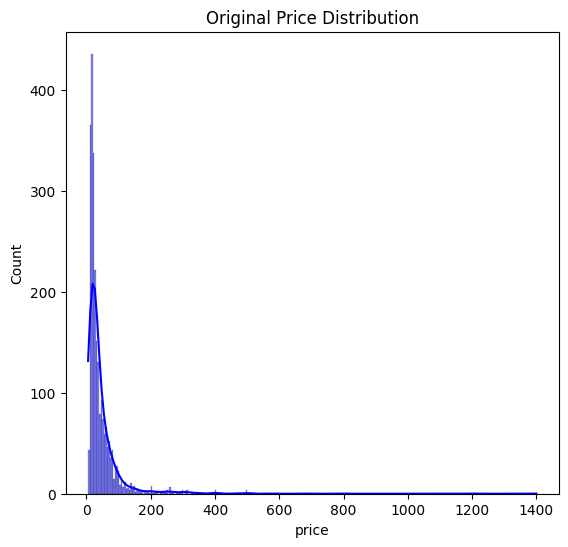

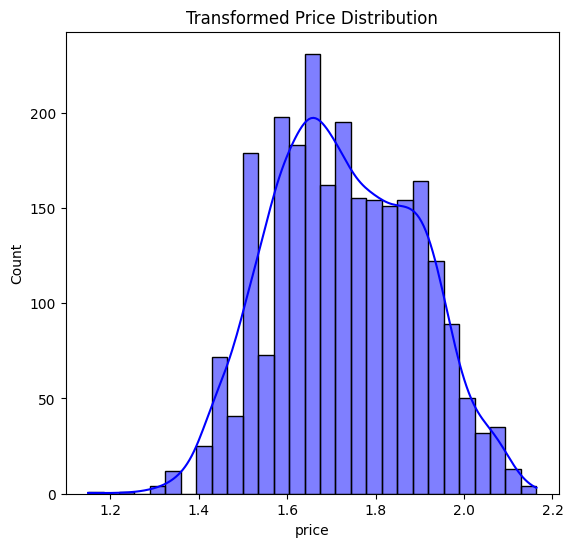

In [25]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
# Drop the 'points' column
# data.drop(columns=['superior_rating'], inplace=True)

# Transform the 'price' column to logarithmic scale
# Check skewness of the 'price' column before transformation
before_skewness = data['price'].skew()
print("Skewness before transformation:", before_skewness)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['price'], kde=True, color="blue")
plt.title('Original Price Distribution')

min_price = data['price'].min()
shift = 0

# If the minimum price is less than or equal to 0, shift all values by (1 - min_price)
if min_price <= 0:
    shift = 1 - min_price
    data['price'] += shift# Apply the Box-Cox transformation
price_transformed, best_lambda = stats.boxcox(data['price'])

# Store the transformed prices back into the DataFrame
data['price'] = price_transformed

# Print the lambda that was found to be best

# Check skewness of the 'price' column after transformation
after_skewness = data['price'].skew()
print("Skewness after transformation:", after_skewness)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['price'], kde=True, color="blue")
plt.title('Transformed Price Distribution')
# Print or further process the modified DataFrame




   points  superior_rating     price                   variety  Crisp  Dry  \
0      91                1  1.829305           Champagne Blend      0    1   
1      87                0  1.612830  Bordeaux-style Red Blend      0    0   
2      87                0  1.782638           Champagne Blend      0    0   
3      90                1  1.788665                      Rosé      1    0   
4      87                0  1.837790                Chardonnay      1    0   

   Finish  Firm  Fresh  Fruit  ...  clean  skin  raspberry  lively  make  \
0       1     0      0      0  ...    0.0   0.0        0.0     0.0   0.0   
1       0     0      0      1  ...    0.0   0.0        0.0     0.0   0.0   
2       0     1      0      1  ...    0.0   0.0        0.0     0.0   0.0   
3       1     0      0      1  ...    0.0   0.0        0.0     0.0   0.0   
4       0     0      0      0  ...    0.0   0.0        0.0     0.0   0.0   

   pack  blanc  yellow       big  add  
0   0.0    0.0     0.0  0.000000  

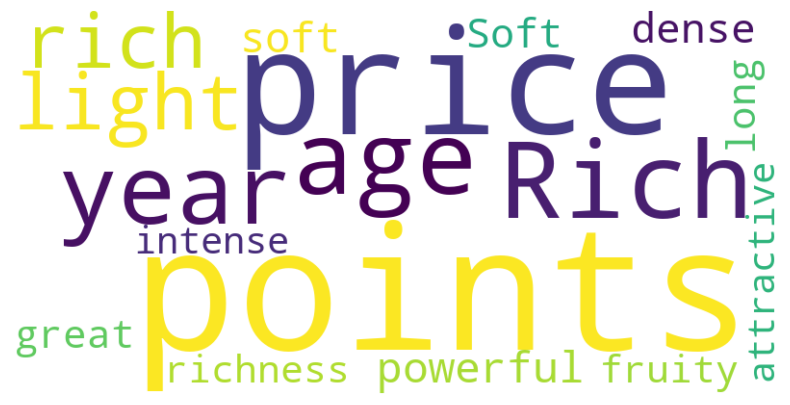

Selected features:
['points', 'superior_rating', 'price', 'Rich', 'Soft', 'age', 'rich', 'year', 'soft', 'light', 'fruity', 'attractive', 'great', 'richness', 'dense', 'intense', 'powerful', 'long', 'variety']


In [23]:
from wordcloud import WordCloud

print(data.head())
numeric_columns = data.select_dtypes(include=['number'])

# Calculate correlation coefficients with 'superior_rating' for numeric columns
correlation = numeric_columns.corrwith(data['points']).abs()

# Select features with correlation greater than magnitude of 0.15
selected_features = correlation[correlation > 0.15].index.tolist()
selected_features.append('variety')


# Print selected features
print("Selected features:")
print(selected_features)

In [20]:
final_df=data[selected_features]
final_df.to_csv('final_df.csv', index=False)
